In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from rdkit import Chem

import warnings
warnings.filterwarnings('ignore')

In [3]:
path_train = 'train.parquet'

In [4]:
con = duckdb.connect()

### Model 1: BRD4 binding

In [6]:
# get data for first batch of training 

df1 = con.query(f"""(SELECT id, molecule_smiles, protein_name, binds 
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'BRD4' AND binds = 0
                    ORDER BY RANDOM()
                    LIMIT 50000) 
                    UNION ALL
                    (SELECT id, molecule_smiles, protein_name, binds
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'BRD4' and binds = 1
                    ORDER BY id
                    LIMIT 50000)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
df1.shape

(100000, 4)

In [8]:
df1.head()

,id,molecule_smiles,protein_name,binds
0,133223292,Cc1sc(Nc2nc(Nc3ccc(S(C)(=O)=O)c(F)c3)nc(Nc3c(B...,BRD4,0
1,134683017,Cn1c(CNc2nc(Nc3ncns3)nc(Nc3c(Br)cc(F)cc3C(=O)N...,BRD4,0
2,250000161,Cn1cc(C2(CNc3nc(NCc4nc(-c5ccncc5)no4)nc(N[C@@H...,BRD4,0
3,121290363,Cc1cc(Nc2nc(NCc3ccc(F)nc3)nc(N[C@H](Cc3ccc(Cl)...,BRD4,0
4,66805389,Cc1cc(C)c(Nc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[C@...,BRD4,0


In [9]:
df1.describe()

,id,binds
count,1.000000e+05,100000.000000
mean,8.131368e+07,0.500000
std,9.003190e+07,0.500003
min,4.500000e+02,0.000000
25%,1.646710e+07,0.000000
50%,1.792842e+07,0.500000
75%,1.478643e+08,1.000000
max,2.952255e+08,1.000000


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               100000 non-null  int64 
 1   molecule_smiles  100000 non-null  object
 2   protein_name     100000 non-null  object
 3   binds            100000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ MB


In [11]:
df1['molecule'] = df1['molecule_smiles'].apply(Chem.MolFromSmiles)
df1.head()

,id,molecule_smiles,protein_name,binds,molecule
0,133223292,Cc1sc(Nc2nc(Nc3ccc(S(C)(=O)=O)c(F)c3)nc(Nc3c(B...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7290>
1,134683017,Cn1c(CNc2nc(Nc3ncns3)nc(Nc3c(Br)cc(F)cc3C(=O)N...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7370>
2,250000161,Cn1cc(C2(CNc3nc(NCc4nc(-c5ccncc5)no4)nc(N[C@@H...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca73e0>
3,121290363,Cc1cc(Nc2nc(NCc3ccc(F)nc3)nc(N[C@H](Cc3ccc(Cl)...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7450>
4,66805389,Cc1cc(C)c(Nc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[C@...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca74c0>


In [12]:
from rdkit.Chem import rdFingerprintGenerator

mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

df1['ecfp'] = df1['molecule'].apply(mfpgen.GetFingerprint).apply(lambda bitvec: list(bitvec))
df1.head()

,id,molecule_smiles,protein_name,binds,molecule,ecfp
0,133223292,Cc1sc(Nc2nc(Nc3ccc(S(C)(=O)=O)c(F)c3)nc(Nc3c(B...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7290>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,134683017,Cn1c(CNc2nc(Nc3ncns3)nc(Nc3c(Br)cc(F)cc3C(=O)N...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7370>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,250000161,Cn1cc(C2(CNc3nc(NCc4nc(-c5ccncc5)no4)nc(N[C@@H...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca73e0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,121290363,Cc1cc(Nc2nc(NCc3ccc(F)nc3)nc(N[C@H](Cc3ccc(Cl)...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca7450>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,66805389,Cc1cc(C)c(Nc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[C@...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x140ca74c0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
X = np.array(df1['ecfp'].tolist())
y = df1['binds']

X.shape

(100000, 2048)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
# split training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

print('training data: ', X_train.shape)
print('test data: ', X_test.shape)

training data:  (80000, 2048)
test data:  (20000, 2048)


In [16]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=4)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

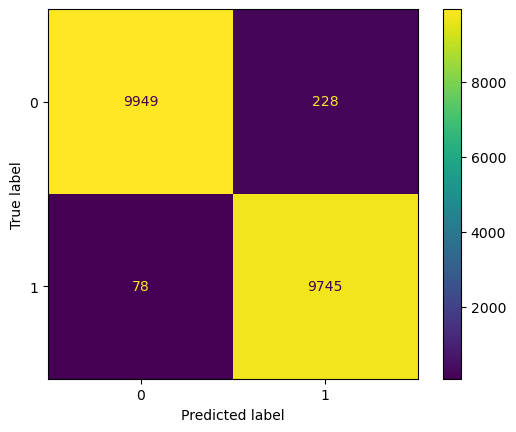

In [17]:
y_hat = clf.predict(X_test)

cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmd.plot()
plt.show()

### Model 2: HSA binding

In [19]:
# get data for second batch of training (protein of interest: HSA)

df2 = con.query(f"""(SELECT id, molecule_smiles, protein_name, binds 
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'HSA' AND binds = 0
                    ORDER BY RANDOM()
                    LIMIT 50000) 
                    UNION ALL
                    (SELECT id, molecule_smiles, protein_name, binds
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'HSA' and binds = 1
                    ORDER BY id
                    LIMIT 50000)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:
df2.head()

,id,molecule_smiles,protein_name,binds
0,46414114,Cc1ccc2cccc(Nc3nc(NCc4cnoc4C4CC4)nc(Nc4c(C(=O)...,HSA,0
1,28820194,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(NCc2ccc(-n3cncn...,HSA,0
2,47573185,Cc1cc(Br)c(C(=O)N[Dy])cc1Nc1nc(NCCC(=O)N2CCN(C...,HSA,0
3,5881423,C=CCC(CC=C)(Nc1nc(NCc2cc(F)cc(F)c2)nc(Nc2ccc(C...,HSA,0
4,118105171,Cc1ccc(CNc2nc(NCc3c(C)sc(C)c3Br)nc(N[C@H](Cc3c...,HSA,0


In [21]:
df2['protein_name'].unique()

array(['HSA'], dtype=object)

In [22]:
df2.shape

(100000, 4)

In [23]:
df2['molecule'] = df2['molecule_smiles'].apply(Chem.MolFromSmiles)
df2.head()

,id,molecule_smiles,protein_name,binds,molecule
0,46414114,Cc1ccc2cccc(Nc3nc(NCc4cnoc4C4CC4)nc(Nc4c(C(=O)...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848820>
1,28820194,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(NCc2ccc(-n3cncn...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x4448487b0>
2,47573185,Cc1cc(Br)c(C(=O)N[Dy])cc1Nc1nc(NCCC(=O)N2CCN(C...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848890>
3,5881423,C=CCC(CC=C)(Nc1nc(NCc2cc(F)cc(F)c2)nc(Nc2ccc(C...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848a50>
4,118105171,Cc1ccc(CNc2nc(NCc3c(C)sc(C)c3Br)nc(N[C@H](Cc3c...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848900>


In [24]:
df2['ecfp'] = df2['molecule'].apply(mfpgen.GetFingerprint).apply(lambda bitvec: list(bitvec))
df2.head()

,id,molecule_smiles,protein_name,binds,molecule,ecfp
0,46414114,Cc1ccc2cccc(Nc3nc(NCc4cnoc4C4CC4)nc(Nc4c(C(=O)...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,28820194,COc1c(F)ccc(C(=O)N[Dy])c1Nc1nc(NCc2ccc(-n3cncn...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x4448487b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,47573185,Cc1cc(Br)c(C(=O)N[Dy])cc1Nc1nc(NCCC(=O)N2CCN(C...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848890>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,5881423,C=CCC(CC=C)(Nc1nc(NCc2cc(F)cc(F)c2)nc(Nc2ccc(C...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848a50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,118105171,Cc1ccc(CNc2nc(NCc3c(C)sc(C)c3Br)nc(N[C@H](Cc3c...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x444848900>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:
X_hsa = np.array(df2['ecfp'].tolist())
y_hsa = df2['binds']

X_hsa.shape

(100000, 2048)

In [26]:
# split training and test data

X_train, X_test, y_train, y_test = train_test_split(X_hsa, y_hsa, test_size=0.2, random_state=33)

print('training data: ', X_train.shape)
print('test data: ', X_test.shape)

training data:  (80000, 2048)
test data:  (20000, 2048)


In [27]:
clf_hsa = RandomForestClassifier(n_estimators=100, n_jobs=4)
clf_hsa.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

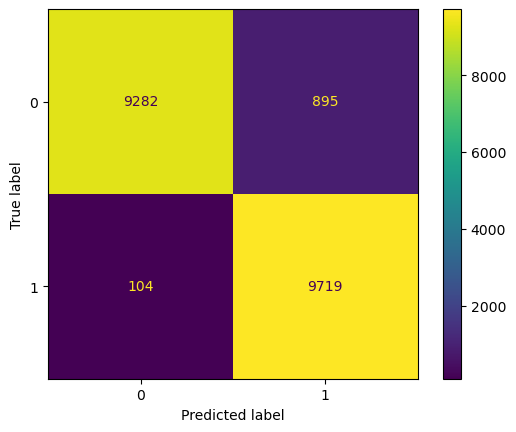

In [28]:
y_hat_hsa = clf_hsa.predict(X_test)

cm = confusion_matrix(y_test, y_hat_hsa)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_hsa.classes_)
cmd.plot()
plt.show()

### Model 3: sEH binding

In [30]:
# get data 

df3 = con.query(f"""(SELECT id, molecule_smiles, protein_name, binds 
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'sEH' AND binds = 0
                    ORDER BY RANDOM()
                    LIMIT 50000) 
                    UNION ALL
                    (SELECT id, molecule_smiles, protein_name, binds
                    FROM parquet_scan('{path_train}')
                    WHERE protein_name = 'sEH' and binds = 1
                    ORDER BY id
                    LIMIT 50000)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [31]:
df3.shape

(100000, 4)

In [32]:
df3.head()

,id,molecule_smiles,protein_name,binds
0,141557060,O=C(N[Dy])c1cnn(-c2ccc(F)cc2)c1Nc1nc(NCCn2cccn...,sEH,0
1,100880672,CCOC(=O)c1cnn(C)c1Nc1nc(NCc2ccsc2C(F)(F)F)nc(N...,sEH,0
2,221531567,Cc1cc(Nc2nc(Nc3nc(Cl)c(C=O)c(Cl)n3)nc(Nc3cnccc...,sEH,0
3,193108643,COc1ccc(Nc2nc(NCc3ncccc3F)nc(Nc3ccc(C(=O)N[Dy]...,sEH,0
4,206191967,COc1cccc(F)c1CNc1nc(NCC2CC(CC(N)=O)CO2)nc(Nc2c...,sEH,0


In [33]:
# convert molecule_smiles to molecule, get ECFPs

df3['molecule'] = df3['molecule_smiles'].apply(Chem.MolFromSmiles)
df3['ecfp'] = df3['molecule'].apply(mfpgen.GetFingerprint).apply(lambda bitvec: list(bitvec))
df3.head()

# for next round of improvement: 
# get ECFPs for unique molecule_smiles (133 million chemicals, saves from doing this step 3x)

,id,molecule_smiles,protein_name,binds,molecule,ecfp
0,141557060,O=C(N[Dy])c1cnn(-c2ccc(F)cc2)c1Nc1nc(NCCn2cccn...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x3e18194d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100880672,CCOC(=O)c1cnn(C)c1Nc1nc(NCc2ccsc2C(F)(F)F)nc(N...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x3e1819690>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,221531567,Cc1cc(Nc2nc(Nc3nc(Cl)c(C=O)c(Cl)n3)nc(Nc3cnccc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x3e1819700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,193108643,COc1ccc(Nc2nc(NCc3ncccc3F)nc(Nc3ccc(C(=O)N[Dy]...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x3e1819770>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,206191967,COc1cccc(F)c1CNc1nc(NCC2CC(CC(N)=O)CO2)nc(Nc2c...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x3e1819a10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [34]:
X_seh = np.array(df3['ecfp'].tolist())
y_seh = df3['binds']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_seh, y_seh, test_size=0.2, random_state=33)

In [36]:
clf_seh = RandomForestClassifier(n_estimators=100, n_jobs=4)
clf_seh.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

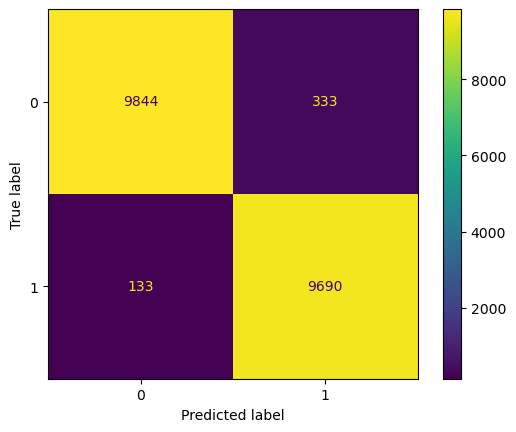

In [37]:
y_hat_seh = clf_seh.predict(X_test)

cm = confusion_matrix(y_test, y_hat_seh)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_seh.classes_)
cmd.plot()
plt.show()

In [38]:
# open test dataset

test_df = pd.read_csv('test.csv')
test_df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
1,295246831,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
3,295246833,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
4,295246834,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA


In [39]:
test_df.shape

(1674896, 6)

In [40]:
test_df.drop(columns=['buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles'], inplace=True)
test_df.head()

,id,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
1,295246831,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
2,295246832,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
3,295246833,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
4,295246834,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA


In [41]:
sub = test_df.iloc[:100,:]
sub.shape

(100, 3)

In [42]:
import time 

start = time.time()

sub['molecule'] = sub['molecule_smiles'].apply(Chem.MolFromSmiles)

end = time.time()

print(end - start)

0.009980916976928711


In [43]:
0.03857421875 * len(test_df) / 100

646.078046875

In [44]:
test_df['molecule_smiles'].nunique()

878022

In [45]:
len(test_df)/878022

1.9075786255925251

In [46]:
test_unique = test_df['molecule_smiles'].unique()
type(test_unique)

numpy.ndarray

In [47]:
len(test_unique)

878022

In [48]:
test_series = pd.Series(test_unique)
type(test_series)

pandas.core.series.Series

In [49]:
test_series[:5]

0    C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...
1    C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...
2    C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...
3    C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...
4    C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...
dtype: object

In [50]:
start = time.time()
test_mol = test_series.apply(Chem.MolFromSmiles)
end = time.time()
print(end-start)

98.94911789894104


In [51]:
start = time.time()
test_fp = test_mol.apply(mfpgen.GetFingerprint)
end = time.time()
print(end-start)

105.56003594398499


In [52]:
len(test_fp[0])

2048

In [53]:
type(test_fp[0])

rdkit.DataStructs.cDataStructs.ExplicitBitVect

In [54]:
a = np.array(test_fp[:10])

In [55]:
from rdkit import DataStructs

test_fp_vec = np.zeros((0,))

DataStructs.ConvertToNumpyArray(test_fp[0], test_fp_vec)

In [56]:
test_fp_vec

array([0., 1., 0., ..., 0., 0., 0.])

In [57]:
df_test_combo = pd.concat([test_series, test_mol, test_fp], axis=1)

In [58]:
df_test_combo.rename(columns={0:'smiles', 1:'molecule', 2:'fingerprint'}, inplace=True)
df_test_combo.head()

,smiles,molecule,fingerprint
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,<rdkit.Chem.rdchem.Mol object at 0x536787680>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,<rdkit.Chem.rdchem.Mol object at 0x536787840>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,<rdkit.Chem.rdchem.Mol object at 0x5367878b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,<rdkit.Chem.rdchem.Mol object at 0x536787920>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,<rdkit.Chem.rdchem.Mol object at 0x536787990>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
fp1 = df_test_combo['fingerprint'][0]
fp1

In [60]:
fp1_np = np.zeros((0,))
DataStructs.ConvertToNumpyArray(fp1, fp1_np)

fp1_np

array([0., 1., 0., ..., 0., 0., 0.])

In [160]:
def to_numpy(fp):
    # Mush, I'm mapping the bitvec to values between 0-256, if it exceeds this will overflow! Just fyi.
    temp = np.zeros((0,), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, temp)
    return temp

In [132]:
df_test_combo.drop(columns=['molecule'], inplace=True)
df_test_combo.head()

,smiles,fingerprint
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [134]:
df_test_combo.shape

(878022, 2)

In [139]:
type(df_test_combo['fingerprint'][0])

rdkit.DataStructs.cDataStructs.ExplicitBitVect

In [141]:
# save this (partially) processed test dataset so I don't have to get the fingerprints again in the future

df_test_combo.to_csv('test_fingerprints.csv')

In [143]:
test2 = pd.read_csv('test_fingerprints.csv')
test2.head()

,Unnamed: 0,smiles,fingerprint
0,0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
1,1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
2,2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
3,3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...
4,4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...


In [145]:
test2['fingerprint'][0]

'<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x76d3c8970>'

In [147]:
type(test2['fingerprint'][0])

str

In [180]:
df_test_combo['ecfp'] = df_test_combo['fingerprint'].apply(to_numpy)

In [182]:
df_test_combo.head()

,smiles,fingerprint,ecfp
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [186]:
type(df_test_combo['ecfp'][0][0])

numpy.uint8

In [188]:
df_test_combo.shape

(878022, 3)

In [190]:
df_test_combo.drop(columns=['fingerprint'], inplace=True)

In [192]:
df_test_combo.head()

,smiles,ecfp
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_test_combo['ecfp_list'] = df_test_combo['ecfp'].apply(lambda x: list(x))

In [198]:
df_test_combo.to_csv('test_fingerprints.csv', index=False)

In [212]:
array = np.array([1,2,3,4])
array_list = list(array)

array

array([1, 2, 3, 4])

In [214]:
array_list

[1, 2, 3, 4]

In [200]:
test3 = pd.read_csv('test_fingerprints.csv')
test3.head()

,smiles,ecfp
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,[0 1 0 ... 0 0 0]
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,[0 1 0 ... 0 0 0]
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,[0 1 0 ... 0 0 0]
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,[0 1 0 ... 0 0 0]
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,[0 1 0 ... 0 0 0]


In [202]:
type(test3['ecfp'][0])

str

TypeError: a bytes-like object is required, not 'list'

In [206]:
test3.head()

,smiles,ecfp,ecfp_np
0,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,[0 1 0 ... 0 0 0],[0 1 0 ... 0 0 0]
1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,[0 1 0 ... 0 0 0],[0 1 0 ... 0 0 0]
2,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,[0 1 0 ... 0 0 0],[0 1 0 ... 0 0 0]
3,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,[0 1 0 ... 0 0 0],[0 1 0 ... 0 0 0]
4,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,[0 1 0 ... 0 0 0],[0 1 0 ... 0 0 0]


In [64]:
# test_df.head()

In [66]:
# clf.predict_proba(test_df['protein_name'][0])

In [67]:
# pred = np.zeros(len(test_df))

# for i, row in test_df.iterrows():
#     ecfp_array = np.array(row['ecfp'].tolist())
#     target = row['protein_name']
    
#     if target == 'BRD4':
#         pred[i] = clf.predict_proba(ecfp_array)
        
#     elif target == 'HSA':
#         pred[i] = clf_hsa.predict_proba(ecfp_array)
        
#     else:
#         pred[i] = clf_seh.predict_proba(ecfp_array)

In [68]:
# predict test data for submission